In [1]:
suppressPackageStartupMessages({
    library(limma)
    library(imputeLCMD)
    library(limma)
    library(ggplot2)
    library(ggsci)
    library(patchwork)
    library(rrcovNA)
    library(ggExtra)

})

options(warn = -1)


impute.perseus <- function(x, width=0.3, shift=1.8) {
  # distributions are induced by measured values in each sample
  data.mean <- colMeans(x, na.rm = TRUE)
  data.sd <- matrixStats::colSds(x, na.rm = TRUE)
  n <- nrow(x)
  z <- rmvnorm(n, mean = data.mean - shift*data.sd , sigma = diag(data.sd*width))
  x[is.na(x)] <- z[is.na(x)]
  return(x)
}


fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}


devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")

ℹ Loading msImpute



In [2]:
ups_data <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD000279/dynamicrangebenchmark/peptides.txt", stringsAsFactors = FALSE)


ups_data <- ups_data[grep("CON__|REV__", ups_data$Leading.razor.protein, invert=TRUE),]


ups_data$PeptideID <- paste(ups_data$Sequence, ups_data$Charges, ups_data$Leading.razor.protein, sep="_")
y <- ups_data[,grep("Intensity.UPS", colnames(ups_data))]
rownames(y) <- ups_data$PeptideID

# confirm UPS peptides are in the expression matrix



y[y == 0] <- NA
keep <- rowSums(!is.na(y)) >= 4


y <- y[keep,]
y <- log2(as.matrix.data.frame(y))
y_dda <- y

table(grepl("ups", rownames(y_dda)))

group <- gsub(".*\\.(UPS[12])_[0-4]+",
              "\\1",
              colnames(y_dda))


FALSE  TRUE 
19628   646 

### Imputation (barycenter + SOTA methods)

In [3]:
y_msImpute <- msImpute(y_dda, 
                       rank.max = 2,
                       method = "v2-mnar", 
                       group = group)



y_MLE <- impute.wrapper.MLE(y_dda)
y_impSeq <- impSeq(y_dda)
y_knn <- impute.wrapper.KNN(y_dda, K = 15)




y_perseus <- impute.perseus(y_dda)

# pcv <- plotCV2(limma::normalizeBetweenArrays(y_perseus,
#                                              method = 'quantile'), 
#                main = "perseus")

y_qrilc <- impute.QRILC(y_dda, 1)[[1]]


sOa_imps <- readRDS("/stornext/Home/data/allstaff/h/hediyehzadeh.s/softImpute_low_rank_experimentation/impute_PXD000279_sOa_filter4obs_noNorm.rds")
names(sOa_imps) <- c("RF","Mice","EM","BPCA","LLS")

sOa_imps <- sOa_imps[c("RF","Mice","EM","BPCA")]

z <- m <- rownames(sOa_imps[[1]])


all(rownames(y_dda) == rownames(sOa_imps[[1]]))

mats <- list(
             "KNN"= y_knn,
             
             "impSeq" = y_impSeq,
             "barycenter" = y_msImpute,
             
             "baseline" = y_dda)





mats <- c(sOa_imps, mats)


Running msImpute version 2

Estimate distribution under MAR assumption

rank is 2

computing lambda0 ...

lambda0 is 5.0999050565704

fit the low-rank model ...

model fitted. 
Imputting missing entries ...

Imputation completed

Compute barycenter of MAR and NMAR distributions v2-mnar



Cluster size 20274 broken into 14728 5546 
Cluster size 14728 broken into 7846 6882 
Cluster size 7846 broken into 2894 4952 
Cluster size 2894 broken into 1853 1041 
Cluster size 1853 broken into 1014 839 
Done cluster 1014 
Done cluster 839 
Done cluster 1853 
Done cluster 1041 
Done cluster 2894 
Cluster size 4952 broken into 2538 2414 
Cluster size 2538 broken into 1315 1223 
Done cluster 1315 
Done cluster 1223 
Done cluster 2538 
Cluster size 2414 broken into 1218 1196 
Done cluster 1218 
Done cluster 1196 
Done cluster 2414 
Done cluster 4952 
Done cluster 7846 
Cluster size 6882 broken into 829 6053 
Done cluster 829 
Cluster size 6053 broken into 1023 5030 
Done cluster 1023 
Cluster size 5030 broken into 1134 3896 
Done cluster 1134 
Cluster size 3896 broken into 2093 1803 
Cluster size 2093 broken into 2077 16 
Cluster size 2077 broken into 672 1405 
Done cluster 672 
Done cluster 1405 
Done cluster 2077 
Done cluster 16 
Done cluster 2093 
Cluster size 1803 broken into 37 1

[1] TRUE

### Differential Expression

In [4]:

design <- model.matrix(~ group)

n_ups <- 500


topN <- list()
fullTables <- list()
fullTables2 <- list()
for(i in seq_along(mats)){
  message("processing ", names(mats)[i])
   E <- normalizeBetweenArrays(mats[[i]], method = "quantile")

   fit <- lmFit(E, design = design)
   
   fit <- eBayes(fit)
   print(summary(decideTests(fit)))

  tp <- topTable(fit, coef=ncol(fit), number = Inf, p.value = 1)
  tp$de <- ifelse(tp$adj.P.Val < 0.05,1,0)
  tp$isUPS <- ifelse(grepl("ups", rownames(tp)),1,0)
  #tp$isdeUPS <- ifelse(tp$isUPS==1 & tp$de==1,1,0)
  tp$TP <- ifelse(tp$de==1 & tp$isUPS==1,1,0) # a ups called DE is a true positive
  tp$FN <- ifelse(tp$de==0 & tp$isUPS==1,1,0) # a ups called not DE is a false negative
  tp$fd <- ifelse(tp$isUPS==0 & tp$de ==1 ,1,0) # & !complete.cases(y_dda[match(rownames(tp), rownames(y_dda)),])
  tp$FDR <- cumsum(tp$fd)/cumsum(tp$de)
  topN[[names(mats)[i]]] <- data.frame(N=seq_len(n_ups),
                                       numUPS=cumsum(tp$isUPS)[seq_len(n_ups)],
                                       FDR=tp$FDR[seq_len(n_ups)],
                                       nominalFDR= ifelse(seq_len(n_ups) == which(tp$adj.P.Val > 0.05)[1],1,0),
                                       method=names(mats)[i])
  
  
  

  fullTables[[names(mats)[i]]] <- data.frame(
    
    
    
    # replace with labels and predictions to use pROC
    predictions = -log10(tp$P.Value),
    labels = tp$isUPS
    
    
    
    )
  
  fullTables2[[names(mats)[i]]] <- data.frame(
    
    
    TP = cumsum(tp$TP),
    FP = cumsum(tp$fd),
    TP_total = sum(tp$TP, na.rm = TRUE),
    FP_total = sum(tp$fd, na.rm = TRUE),
    FN_total = sum(tp$FN, na.rm = TRUE)
    
    

    
    )
}


topN <- do.call(rbind, topN)
fullTables <- do.call(rbind, fullTables)
fullTables$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables))


fullTables2 <- do.call(rbind, fullTables2)
fullTables2$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables2))

processing RF



       (Intercept) groupUPS2
Down             0       228
NotSig           0     19977
Up           20274        69


processing Mice



       (Intercept) groupUPS2
Down             0       117
NotSig           0     20095
Up           20274        62


processing EM



       (Intercept) groupUPS2
Down             0       120
NotSig           0     20092
Up           20274        62


processing BPCA



       (Intercept) groupUPS2
Down             0        85
NotSig           0     20132
Up           20274        57


processing KNN



       (Intercept) groupUPS2
Down             0       162
NotSig           0     20062
Up           20274        50


processing impSeq



       (Intercept) groupUPS2
Down             0       120
NotSig           0     20091
Up           20274        63


processing barycenter



       (Intercept) groupUPS2
Down             0       185
NotSig           0     20022
Up           20274        67


processing baseline



       (Intercept) groupUPS2
Down             0       135
NotSig           0     19733
Up           20274        59


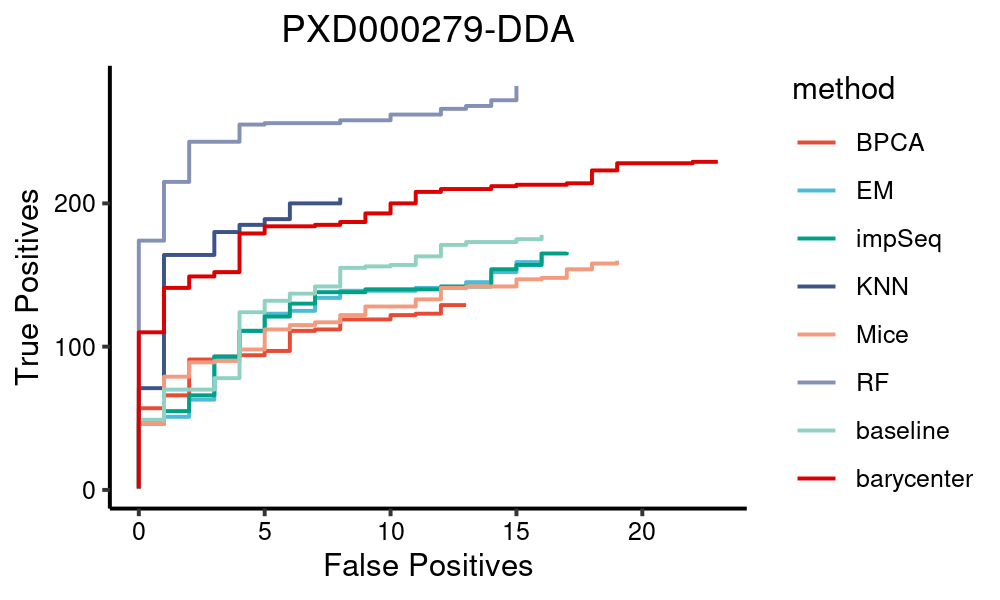

In [5]:
fig.size(3, 5)


fullTables2$method <- factor(fullTables2$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","baseline","barycenter"))

p1 <- ggplot(fullTables2, aes(y=TP, x=FP, color=method, group = method)) +
#   geom_line(size=1) + 
  geom_line() + 
  scale_color_npg() + theme_classic() +
  theme(plot.title = element_text(hjust = 0.5), axis.text=element_text(colour="black")) + 
  labs(title = "PXD000279-DDA") + xlab("False Positives") + ylab("True Positives")

p1

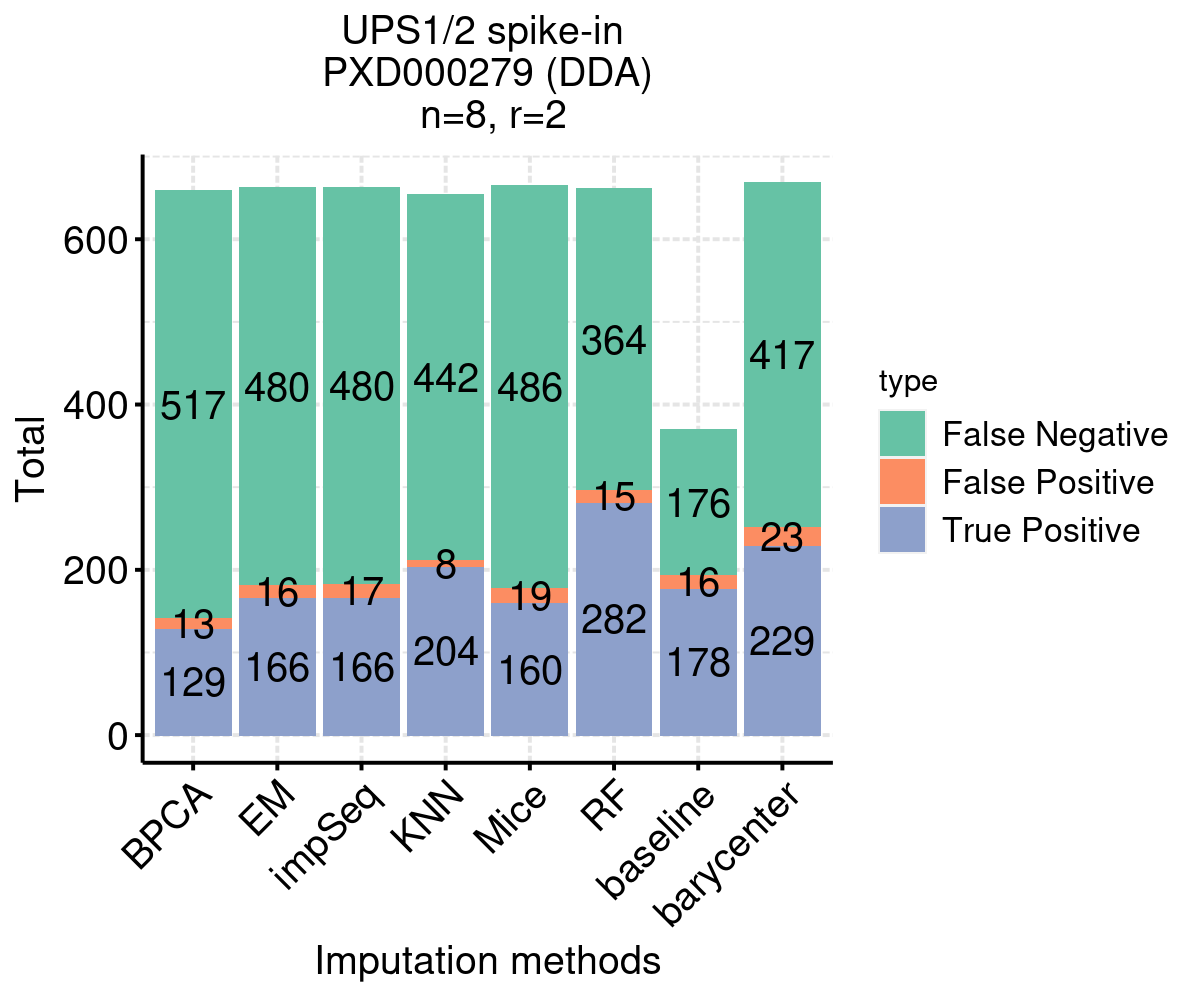

In [6]:
fig.size(5,6)

# Barplot of True positive, false positives and false negatives for all methods at FDR 0.05
ggdat <- fullTables2[,grep("method|total", colnames(fullTables2))]
ggdat <- ggdat[!duplicated(ggdat$method),]
colnames(ggdat) <- gsub("_total", "", colnames(ggdat))


ggdat <- reshape2::melt(ggdat, id = "method")
ggdat$method <- factor(ggdat$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","baseline","barycenter"))


ggdat$variable <- gsub("TP", "True Positive", ggdat$variable)
ggdat$variable <- gsub("FP", "False Positive", ggdat$variable)
ggdat$variable <- gsub("FN", "False Negative", ggdat$variable)


# png(file = "~/barplot_PXD000279.png",
#     width=6,height=5,units="in",res=1200)

p <- ggplot(ggdat, aes(x=method, y = value, fill = variable, label=value)) +
  geom_bar(stat = "identity", position="stack") +
  geom_text(size = 5, position = position_stack(vjust = 0.5)) +
  xlab('Imputation methods') + ylab('Total') + labs(fill="type", title = "UPS1/2 spike-in \nPXD000279 (DDA)\n n=8, r=2") +  
  # scale_fill_jco() +
  scale_fill_brewer(palette = "Set2") +
  #scale_fill_brewer(palette = "Dark2", direction = -1) +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

# print(p)
# dev.off()
p


FALSE  TRUE 
19927   347 

png 
  2

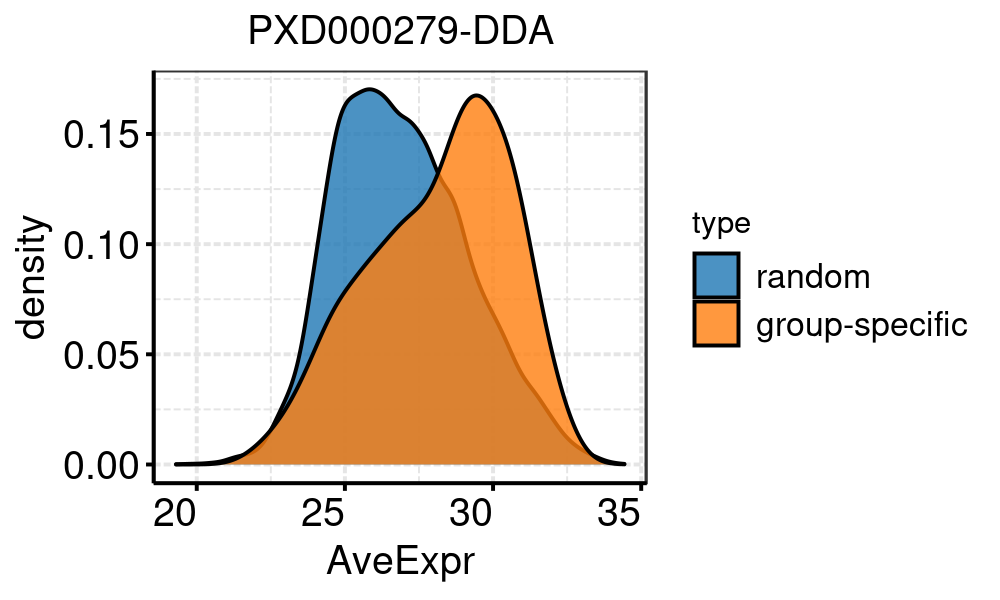

In [7]:
fig.size(3,5)

# Visualization of the ebm metric for assessment of missing types
hdp <- selectFeatures(y_dda,
                      method="ebm", group = group)

#hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1
# hist(ebms)
# plot(hdp$AveExpr, ebms, pch = 16, cex = 0.3)




ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))


png(file = "~/hist_missingtype_PXD000279.png",
    width=5,height=3,units="in",res=1200)

p <- ggplot(ggdat, aes(x=AveExpr, fill = type)) +
  geom_density(alpha = 0.8) + scale_fill_d3() +
  theme_bw() + labs(title = "PXD000279-DDA")  +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

print(p)
dev.off()
p

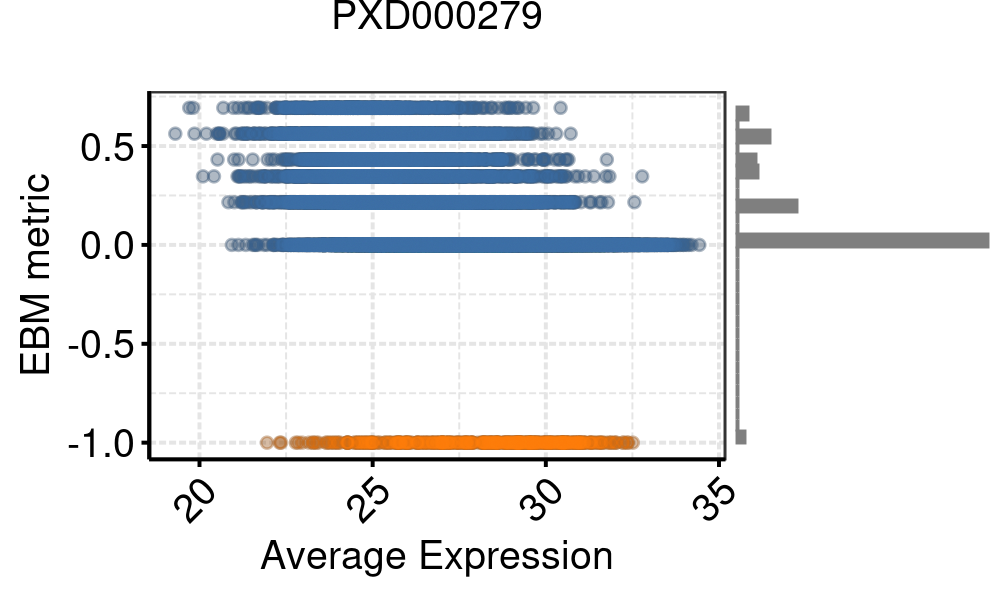

In [8]:
fig.size(3,5)

p <- ggplot(ggdat, aes(x=AveExpr, y = metric)) +
  geom_point(alpha = 0.2) + 
  geom_point(data = subset(ggdat, metric == -1),alpha = 0.2, 
             color = "#FF7F0EFF") + 
  geom_point(data = subset(ggdat, metric != -1),alpha = 0.2, color = "#3E71A8") +
  #stat_bin_2d() +
  #geom_rug(sides = "b", alpha = 0.05) +
  theme_bw() +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) + labs(x='Average Expression', y = 'EBM metric', title='PXD000279')

p1 <- ggMarginal(p, type="histogram", margins = "y", 
                 fill = "gray50", color = "gray50", 
                 size = 2.1)

p1 

### Session information

In [9]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /stornext/System/data/apps/R/R-4.1.2/lib64/R/lib/libRblas.so
LAPACK: /stornext/System/data/apps/R/R-4.1.2/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] msImpute_1.3.3      ggExtra_0.9         rrcovNA_0.4-15     
 [4] rrcov_1.5-5         robustbase_0.93-8   patchwork_1.1.1    
 [7] ggsci_2.9           ggplot2_3.3.4       imputeLCMD_2.0     
[10] impute_1.66.0    